In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Incendios Forestales

El objetivo es crear 2 nuevas variables:

* Hay o no incendio (si area > 0, hay incendio, eoc no)

* Magnitud del Incenido (usar el área en escala logarítmica si área > 0).

Se deben proponer 2 modelos, uno de clasificación y uno de regresión.
Al final habrá que comparar el modelo contra los datos reales para ver el poder predictivo.
No importa que se tenga el mejor modelo, lo que importa es entender que se está haciendo,
entender los pasos que se están siguiendo, asi como saber que modelos se conocen para dichos procesos.

Entragables: 
Explicar la metodologia que se uso para cada modelo

Requerimientos mínimos:  
Apoyo gráfico
una medida de desempeño, 
explicar por que se uso dicho modelo.

In [ ]:
url = 'https://raw.githubusercontent.com/AngelGuadarrama/Forest-Fires/main/forestfires.csv'
data = pd.read_csv(url)
data.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.20,26.20,94.30,5.10,8.20,51,6.70,0.00,0.00
1,7,4,oct,tue,90.60,35.40,669.10,6.70,18.00,33,0.90,0.00,0.00
2,7,4,oct,sat,90.60,43.70,686.90,6.70,14.60,33,1.30,0.00,0.00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
X        517 non-null int64
Y        517 non-null int64
month    517 non-null object
day      517 non-null object
FFMC     517 non-null float64
DMC      517 non-null float64
DC       517 non-null float64
ISI      517 non-null float64
temp     517 non-null float64
RH       517 non-null int64
wind     517 non-null float64
rain     517 non-null float64
area     517 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [ ]:
#Creamos nuestras nuevas columnas
data['incendio']=[value > 0 for value in data.area] 
data['magnitud']=np.log(data[data.area> 0]['area'])
data.fillna({'magnitud': 0}, inplace=True)

Variables Numericas

In [ ]:
data[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain']].describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
count,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00,517.00
mean,4.67,4.30,90.64,110.87,547.94,9.02,18.89,44.29,4.02,0.02
std,2.31,1.23,5.52,64.05,248.07,4.56,5.81,16.32,1.79,0.30
min,1.00,2.00,18.70,1.10,7.90,0.00,2.20,15.00,0.40,0.00
25%,3.00,4.00,90.20,68.60,437.70,6.50,15.50,33.00,2.70,0.00
50%,4.00,4.00,91.60,108.30,664.20,8.40,19.30,42.00,4.00,0.00
75%,7.00,5.00,92.90,142.40,713.90,10.80,22.80,53.00,4.90,0.00
max,9.00,9.00,96.20,291.30,860.60,56.10,33.30,100.00,9.40,6.40


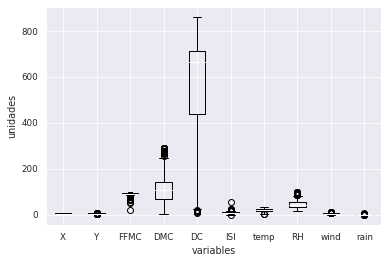

In [ ]:
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("bright")

data[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain']].boxplot()
plt.xlabel('variables')
plt.ylabel('unidades')
plt.show()       

In [ ]:
data['DC_log']=np.log(data.DC) #Esta columna tiene una varianza muy alta
data.drop(['DC'], inplace=True, axis=1)

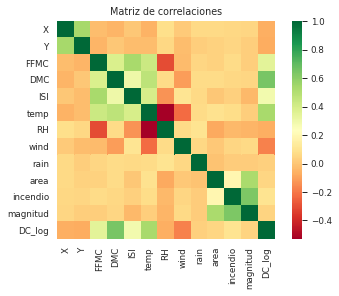

In [ ]:
#Quitaremos RH ya que tiene correlacion con la temperatura
sns.heatmap(data.corr(), square= True, cmap='RdYlGn') 
plt.title("Matriz de correlaciones")
plt.show

data.drop(['RH'], inplace=True, axis=1)

In [ ]:
data.columns

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'wind',
       'rain', 'area', 'incendio', 'magnitud'],
      dtype='object')

Variables categoricas: aplicaremos dummys en el caso de regresión y target mean en el caso de clasificación.


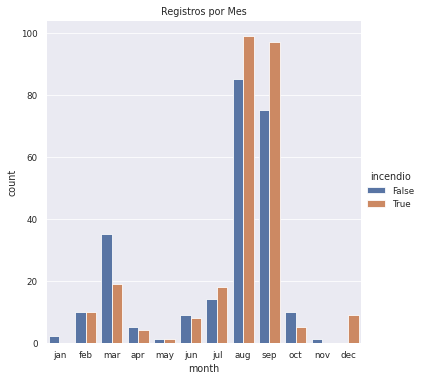

In [ ]:
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("deep")

order=["jan","feb","mar","apr","may","jun", "jul","aug","sep","oct","nov","dec"]
sns.catplot(data=data, kind="count", x="month", order=order, hue="incendio")
plt.title('Registros por Mes')
plt.show()

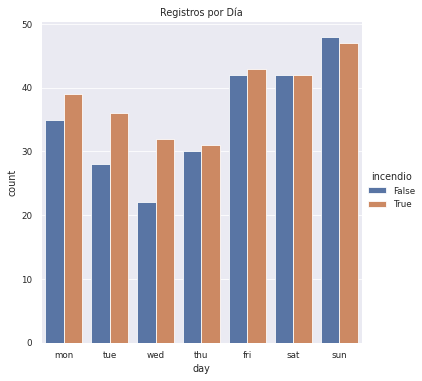

In [ ]:
sns.set_style("darkgrid")
sns.set_context("paper")
sns.set_palette("deep")

order=["mon","tue","wed","thu","fri","sat","sun"]
sns.catplot(data=data, kind="count", x="day", order=order, hue="incendio")
plt.title('Registros por Día')
plt.show()

In [ ]:
data['day'].replace({'mon':'0','tue':'0','wed':'0','thu':'0','fri':'1','sat':'1','sun':'1'}, inplace=True)
data.day=data[['day']].apply(lambda x: x.astype('float64'), axis=0)

In [ ]:
data.head()

,X,Y,month,day,FFMC,DMC,ISI,temp,wind,rain,area,incendio,magnitud,DC_log
0,7,5,mar,1.00,86.20,26.20,5.10,8.20,6.70,0.00,0.00,False,0.00,4.55
1,7,4,oct,0.00,90.60,35.40,6.70,18.00,0.90,0.00,0.00,False,0.00,6.51
2,7,4,oct,1.00,90.60,43.70,6.70,14.60,1.30,0.00,0.00,False,0.00,6.53
3,8,6,mar,1.00,91.70,33.30,9.00,8.30,4.00,0.20,0.00,False,0.00,4.35
4,8,6,mar,1.00,89.30,51.30,9.60,11.40,1.80,0.00,0.00,False,0.00,4.63


Modelo de Clasificación

Se utiliza el método Target Mean para la columna Mes al tener más de 10 categoriías en esta columna. Se utiliza lazypredict para ver el el rendimientos de 30 modelos de machine learning. Las metrica que se utilizo fue AUC por su interpretabilidad conforme al azar , f1 score y la clásica matriz de confusión. 

In [ ]:
!pip install lazypredict

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from lazypredict.Supervised import LazyClassifier, LazyRegressor

In [ ]:
def test_mean_target_encoding(train, test, target, categorical, alpha=5):
    # Calculate global mean on the train data
    global_mean = train[target].mean()
    
    # Group by the categorical feature and calculate its properties
    train_groups = train.groupby(categorical)
    category_sum = train_groups[target].sum()
    category_size = train_groups.size()
    
    # Calculate smoothed mean target statistics
    train_statistics = (category_sum + global_mean * alpha) / (category_size + alpha)
    
    # Apply statistics to the test data and fill new categories
    test_feature = test[categorical].map(train_statistics).fillna(global_mean)
    return test_feature.values


def train_mean_target_encoding(train, target, categorical, alpha=5):
    # Create 5-fold cross-validation
    kf = KFold(n_splits=5, random_state=2424, shuffle=True)
    train_feature = pd.Series(index=train.index)
    
    # For each folds split
    for train_index, test_index in kf.split(train):
        cv_train, cv_test = train.iloc[train_index], train.iloc[test_index]
      
        # Calculate out-of-fold statistics and apply to cv_test
        cv_test_feature = test_mean_target_encoding(cv_train, cv_test, target, categorical, alpha)
        
        # Save new feature for this particular fold
        train_feature.iloc[test_index] = cv_test_feature       
    return train_feature.values


def mean_target_encoding(train, test, target, categorical, alpha=5):
  
    # Get the train feature
    train_feature = train_mean_target_encoding(train, target, categorical, alpha)
    # Get the test feature
    test_feature = test_mean_target_encoding(train, test, target, categorical, alpha)
    
    # Return new features to add to the model
    return train_feature, test_feature

100%|██████████| 29/29 [00:01<00:00, 18.63it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
ExtraTreeClassifier                0.65  ...        0.02
BaggingClassifier                  0.58  ...        0.06
ExtraTreesClassifier               0.60  ...        0.18
AdaBoostClassifier                 0.62  ...        0.14
NearestCentroid                    0.63  ...        0.03
LGBMClassifier                     0.62  ...        0.07
PassiveAggressiveClassifier        0.54  ...        0.02
RandomForestClassifier             0.58  ...        0.23
CalibratedClassifierCV             0.58  ...        0.14
XGBClassifier                      0.56  ...        0.18
NuSVC                              0.56  ...        0.04
QuadraticDiscriminantAnalysis      0.44  ...        0.02
GaussianNB                         0.42  ...        0.03
BernoulliNB                        0.54  ...        0.02
KNeighborsClassifier               0.52  ...        0.02
LabelPropagation               

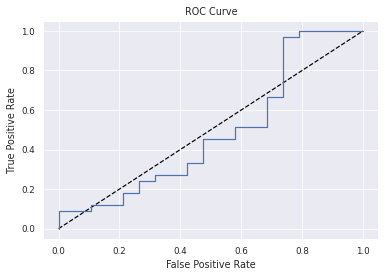

AUC: 0.4896331738437002
              precision    recall  f1-score   support

       False       0.30      0.32      0.31        19
        True       0.59      0.58      0.58        33

    accuracy                           0.48        52
   macro avg       0.45      0.45      0.45        52
weighted avg       0.49      0.48      0.48        52

[[0.11538462 0.26923077]
 [0.25       0.36538462]]


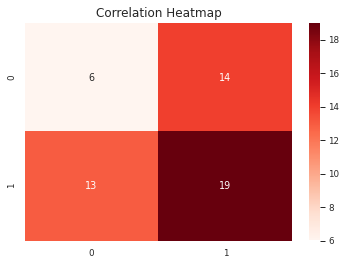

100%|██████████| 29/29 [00:01<00:00, 19.18it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
DummyClassifier                    0.63  ...        0.02
PassiveAggressiveClassifier        0.58  ...        0.02
DecisionTreeClassifier             0.52  ...        0.02
Perceptron                         0.50  ...        0.02
LabelPropagation                   0.48  ...        0.04
SVC                                0.46  ...        0.03
LGBMClassifier                     0.46  ...        0.06
QuadraticDiscriminantAnalysis      0.50  ...        0.02
LabelSpreading                     0.46  ...        0.05
ExtraTreesClassifier               0.46  ...        0.16
RandomForestClassifier             0.44  ...        0.22
CalibratedClassifierCV             0.40  ...        0.28
ExtraTreeClassifier                0.44  ...        0.02
SGDClassifier                      0.46  ...        0.02
XGBClassifier                      0.42  ...        0.07
RidgeClassifierCV              

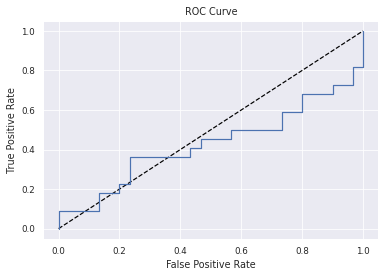

AUC: 0.4303030303030303
              precision    recall  f1-score   support

       False       0.47      0.27      0.34        30
        True       0.37      0.59      0.46        22

    accuracy                           0.40        52
   macro avg       0.42      0.43      0.40        52
weighted avg       0.43      0.40      0.39        52

[[0.15384615 0.17307692]
 [0.42307692 0.25      ]]


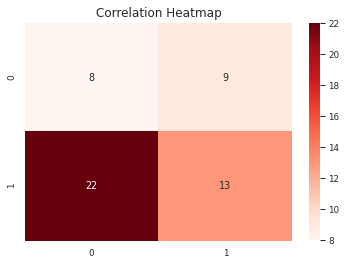

100%|██████████| 29/29 [00:01<00:00, 21.55it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
DecisionTreeClassifier             0.65  ...        0.02
LabelPropagation                   0.63  ...        0.03
LabelSpreading                     0.63  ...        0.04
RandomForestClassifier             0.62  ...        0.21
NuSVC                              0.58  ...        0.04
DummyClassifier                    0.58  ...        0.01
BaggingClassifier                  0.56  ...        0.06
CalibratedClassifierCV             0.58  ...        0.13
ExtraTreesClassifier               0.56  ...        0.17
SVC                                0.56  ...        0.03
RidgeClassifierCV                  0.54  ...        0.02
NearestCentroid                    0.54  ...        0.02
Perceptron                         0.50  ...        0.02
LinearDiscriminantAnalysis         0.52  ...        0.03
LogisticRegression                 0.52  ...        0.03
RidgeClassifier                

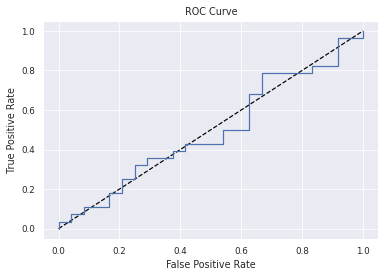

AUC: 0.49404761904761907
              precision    recall  f1-score   support

       False       0.47      0.38      0.42        24
        True       0.55      0.64      0.59        28

    accuracy                           0.52        52
   macro avg       0.51      0.51      0.50        52
weighted avg       0.51      0.52      0.51        52

[[0.17307692 0.19230769]
 [0.28846154 0.34615385]]


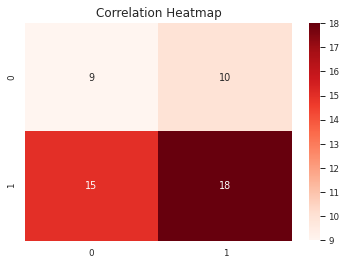

100%|██████████| 29/29 [00:01<00:00, 21.52it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
ExtraTreesClassifier               0.60  ...        0.16
DecisionTreeClassifier             0.58  ...        0.02
SVC                                0.60  ...        0.03
KNeighborsClassifier               0.58  ...        0.02
ExtraTreeClassifier                0.58  ...        0.02
NuSVC                              0.58  ...        0.04
RandomForestClassifier             0.54  ...        0.23
QuadraticDiscriminantAnalysis      0.42  ...        0.02
LabelPropagation                   0.48  ...        0.03
LabelSpreading                     0.48  ...        0.04
LGBMClassifier                     0.50  ...        0.07
DummyClassifier                    0.52  ...        0.01
LogisticRegression                 0.48  ...        0.03
XGBClassifier                      0.50  ...        0.08
BernoulliNB                        0.52  ...        0.01
SGDClassifier                  

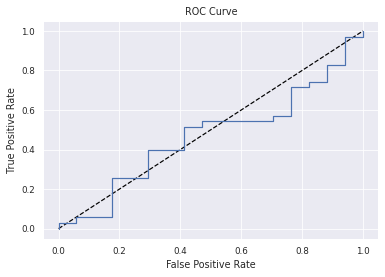

AUC: 0.4689075630252101
              precision    recall  f1-score   support

       False       0.37      0.59      0.45        17
        True       0.72      0.51      0.60        35

    accuracy                           0.54        52
   macro avg       0.55      0.55      0.53        52
weighted avg       0.61      0.54      0.55        52

[[0.19230769 0.32692308]
 [0.13461538 0.34615385]]


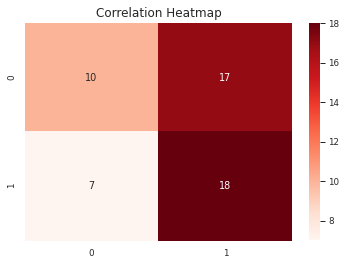

100%|██████████| 29/29 [00:01<00:00, 21.09it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
LinearSVC                          0.62  ...        0.07
LinearDiscriminantAnalysis         0.62  ...        0.03
RidgeClassifierCV                  0.62  ...        0.02
RidgeClassifier                    0.62  ...        0.02
DecisionTreeClassifier             0.62  ...        0.03
LogisticRegression                 0.62  ...        0.03
AdaBoostClassifier                 0.60  ...        0.12
KNeighborsClassifier               0.58  ...        0.02
SGDClassifier                      0.58  ...        0.02
BernoulliNB                        0.58  ...        0.02
SVC                                0.56  ...        0.03
ExtraTreeClassifier                0.54  ...        0.02
GaussianNB                         0.54  ...        0.02
PassiveAggressiveClassifier        0.52  ...        0.02
NearestCentroid                    0.52  ...        0.02
NuSVC                          

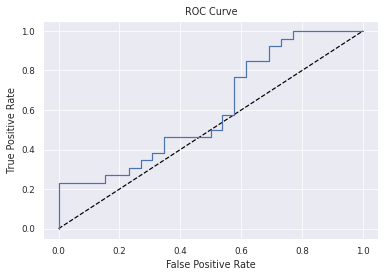

AUC: 0.6065088757396451
              precision    recall  f1-score   support

       False       0.71      0.38      0.50        26
        True       0.58      0.85      0.69        26

    accuracy                           0.62        52
   macro avg       0.65      0.62      0.59        52
weighted avg       0.65      0.62      0.59        52

[[0.19230769 0.07692308]
 [0.30769231 0.42307692]]


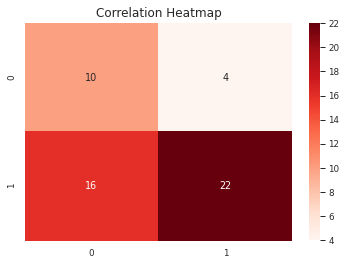

100%|██████████| 29/29 [00:01<00:00, 20.81it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
BaggingClassifier                  0.69  ...        0.06
DecisionTreeClassifier             0.63  ...        0.02
NuSVC                              0.58  ...        0.03
ExtraTreesClassifier               0.58  ...        0.18
LGBMClassifier                     0.58  ...        0.06
RandomForestClassifier             0.58  ...        0.24
AdaBoostClassifier                 0.56  ...        0.12
XGBClassifier                      0.56  ...        0.07
LabelPropagation                   0.56  ...        0.03
LabelSpreading                     0.56  ...        0.04
DummyClassifier                    0.54  ...        0.02
SVC                                0.52  ...        0.03
NearestCentroid                    0.52  ...        0.02
PassiveAggressiveClassifier        0.54  ...        0.02
CalibratedClassifierCV             0.48  ...        0.13
RidgeClassifier                

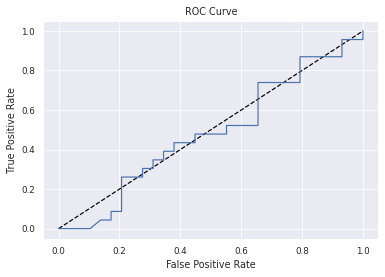

AUC: 0.48050974512743627
              precision    recall  f1-score   support

       False       0.57      0.28      0.37        29
        True       0.45      0.74      0.56        23

    accuracy                           0.48        52
   macro avg       0.51      0.51      0.46        52
weighted avg       0.52      0.48      0.45        52

[[0.15384615 0.11538462]
 [0.40384615 0.32692308]]


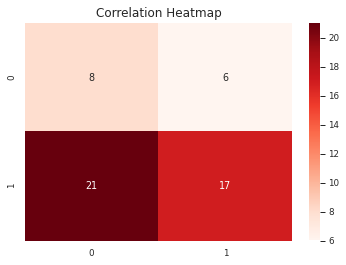

100%|██████████| 29/29 [00:01<00:00, 20.76it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
SVC                                0.65  ...        0.03
XGBClassifier                      0.63  ...        0.08
NearestCentroid                    0.63  ...        0.02
BernoulliNB                        0.62  ...        0.02
DummyClassifier                    0.62  ...        0.02
QuadraticDiscriminantAnalysis      0.62  ...        0.02
BaggingClassifier                  0.62  ...        0.06
LGBMClassifier                     0.60  ...        0.07
PassiveAggressiveClassifier        0.60  ...        0.02
RandomForestClassifier             0.60  ...        0.24
LabelSpreading                     0.58  ...        0.04
Perceptron                         0.58  ...        0.02
LabelPropagation                   0.58  ...        0.04
GaussianNB                         0.58  ...        0.02
ExtraTreesClassifier               0.58  ...        0.17
SGDClassifier                  

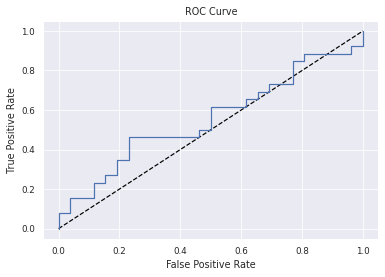

AUC: 0.5562130177514794
              precision    recall  f1-score   support

       False       0.55      0.46      0.50        26
        True       0.53      0.62      0.57        26

    accuracy                           0.54        52
   macro avg       0.54      0.54      0.54        52
weighted avg       0.54      0.54      0.54        52

[[0.23076923 0.19230769]
 [0.26923077 0.30769231]]


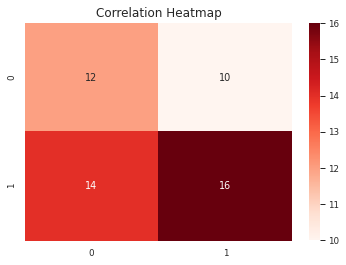

100%|██████████| 29/29 [00:01<00:00, 20.57it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
LabelPropagation                   0.69  ...        0.03
LabelSpreading                     0.69  ...        0.04
NuSVC                              0.67  ...        0.04
SGDClassifier                      0.63  ...        0.02
ExtraTreesClassifier               0.63  ...        0.17
ExtraTreeClassifier                0.63  ...        0.02
LGBMClassifier                     0.61  ...        0.07
XGBClassifier                      0.61  ...        0.08
RandomForestClassifier             0.61  ...        0.23
AdaBoostClassifier                 0.63  ...        0.13
BaggingClassifier                  0.59  ...        0.06
NearestCentroid                    0.61  ...        0.02
DummyClassifier                    0.59  ...        0.02
BernoulliNB                        0.59  ...        0.02
LinearSVC                          0.57  ...        0.06
RidgeClassifier                

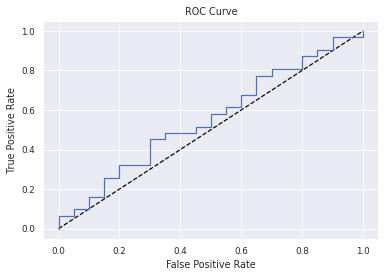

AUC: 0.5564516129032259
              precision    recall  f1-score   support

       False       0.42      0.40      0.41        20
        True       0.62      0.65      0.63        31

    accuracy                           0.55        51
   macro avg       0.52      0.52      0.52        51
weighted avg       0.55      0.55      0.55        51

[[0.15686275 0.21568627]
 [0.23529412 0.39215686]]


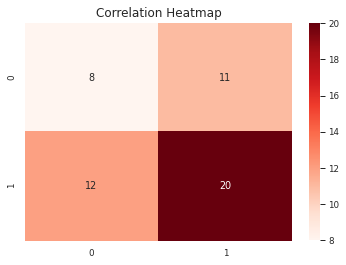

100%|██████████| 29/29 [00:01<00:00, 18.41it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
NuSVC                              0.69  ...        0.04
RandomForestClassifier             0.69  ...        0.23
LGBMClassifier                     0.67  ...        0.07
DecisionTreeClassifier             0.67  ...        0.02
XGBClassifier                      0.67  ...        0.09
LabelSpreading                     0.65  ...        0.05
LabelPropagation                   0.65  ...        0.03
KNeighborsClassifier               0.63  ...        0.02
ExtraTreesClassifier               0.63  ...        0.17
AdaBoostClassifier                 0.63  ...        0.12
QuadraticDiscriminantAnalysis      0.63  ...        0.02
DummyClassifier                    0.61  ...        0.02
GaussianNB                         0.65  ...        0.02
NearestCentroid                    0.61  ...        0.02
SVC                                0.57  ...        0.03
BaggingClassifier              

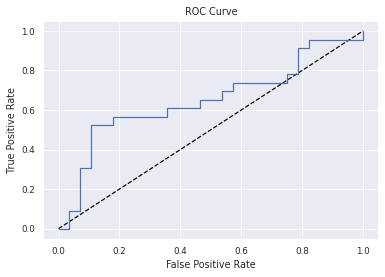

AUC: 0.6521739130434783
              precision    recall  f1-score   support

       False       0.65      0.39      0.49        28
        True       0.50      0.74      0.60        23

    accuracy                           0.55        51
   macro avg       0.57      0.57      0.54        51
weighted avg       0.58      0.55      0.54        51

[[0.21568627 0.11764706]
 [0.33333333 0.33333333]]


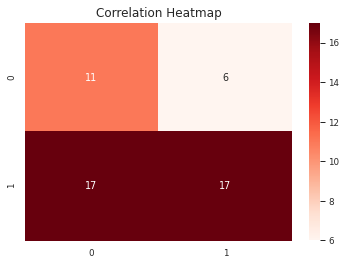

100%|██████████| 29/29 [00:01<00:00, 19.50it/s]


                               Accuracy  ...  Time Taken
Model                                    ...            
NearestCentroid                    0.69  ...        0.03
SVC                                0.67  ...        0.03
XGBClassifier                      0.67  ...        0.09
BaggingClassifier                  0.67  ...        0.07
ExtraTreeClassifier                0.65  ...        0.02
ExtraTreesClassifier               0.65  ...        0.18
BernoulliNB                        0.61  ...        0.02
LinearSVC                          0.59  ...        0.06
RidgeClassifierCV                  0.59  ...        0.03
LogisticRegression                 0.59  ...        0.02
Perceptron                         0.61  ...        0.02
LabelPropagation                   0.61  ...        0.04
RandomForestClassifier             0.61  ...        0.24
NuSVC                              0.59  ...        0.04
RidgeClassifier                    0.57  ...        0.02
LabelSpreading                 

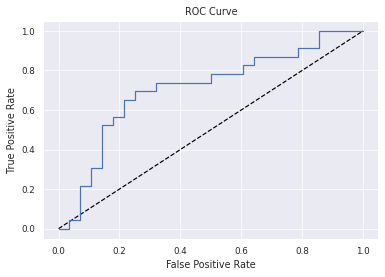

AUC: 0.7096273291925466
              precision    recall  f1-score   support

       False       0.77      0.36      0.49        28
        True       0.53      0.87      0.66        23

    accuracy                           0.59        51
   macro avg       0.65      0.61      0.57        51
weighted avg       0.66      0.59      0.56        51

[[0.19607843 0.05882353]
 [0.35294118 0.39215686]]


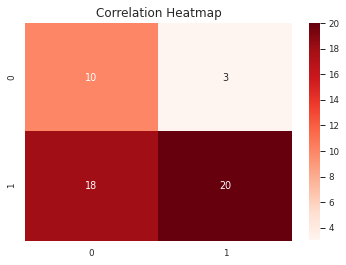

In [ ]:
# Create n-fold cross-validation
kf = KFold(n_splits=10, random_state=123, shuffle=True)
roc_auc_score_list=[]

# For each folds split
for train_index, test_index in kf.split(data):
    
    cv_train, cv_test = data.iloc[train_index], data.iloc[test_index]

    cv_train['month_enc'], cv_test['month_enc'] = mean_target_encoding(train=cv_train,
                                                                           test=cv_test,
                                                                           target='incendio',
                                                                           categorical='month',
                                                                           alpha=5)

    #print(cv_train_dm.shape, cv_test_dm.shape)
    #print(cv_train.shape, cv_test.shape)

    #Estandarizamos las variables numericas
    ss1=StandardScaler()
    ss2=StandardScaler()
    ss3=StandardScaler()
    ss4=StandardScaler()
    ss5=StandardScaler()
    ss6=StandardScaler()
    ss7=StandardScaler()
    ss8=StandardScaler()
    ss9=StandardScaler()
    ss10=StandardScaler()

    ss1.fit(cv_train[['X']])
    ss2.fit(cv_train[['Y']])    
    ss3.fit(cv_train[['FFMC']])
    ss4.fit(cv_train[['DMC']])
    ss5.fit(cv_train[['DC_log']])
    ss6.fit(cv_train[['ISI']])
    ss7.fit(cv_train[['temp']])
    #ss8.fit(cv_train[['RH']])
    ss9.fit(cv_train[['wind']])
    ss10.fit(cv_train[['rain']])

    cv_train_enc=pd.concat([pd.DataFrame(ss1.transform(cv_train[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_train[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_train[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_train[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_train[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_train[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_train[['temp']]), columns=['temp']),
                           #pd.DataFrame(ss8.transform(cv_train[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_train[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_train[['rain']]), columns=['rain']) ], axis=1)
    
    cv_test_enc=pd.concat([pd.DataFrame(ss1.transform(cv_test[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_test[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_test[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_test[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_test[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_test[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_test[['temp']]), columns=['temp']),
                           #pd.DataFrame(ss8.transform(cv_test[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_test[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_test[['rain']]), columns=['rain']) ], axis=1)
    

    #Training
    X_train, y_train= pd.concat([cv_train_enc.reset_index(), 
                                 cv_train[['month_enc']].reset_index(),
                                 cv_train[['day']].reset_index()], axis=1), cv_train[['incendio']]
    X_test, y_test= pd.concat([cv_test_enc.reset_index(), 
                               cv_test[['month_enc']].reset_index(),
                               cv_test[['day']].reset_index()], axis=1), cv_test[['incendio']]
    
    X_train.drop(['index'], inplace=True, axis=1)
    X_test.drop(['index'], inplace=True, axis=1)
    
    #print(X_train.head())
    
    clf= LazyClassifier(verbose=0, ignore_warnings=True)
    models, predictions=clf.fit(X_train, X_test, y_train, y_test)
    print(models)

    logreg= LogisticRegression()
    logreg.fit(X_train.values, y_train.values.ravel())
     
    y_pred= logreg.predict(X_test) 
    y_pred_proba= logreg.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test.values, y_pred_proba)
    
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

    score=roc_auc_score(y_test, y_pred_proba)
    roc_auc_score_list.append(score) 
    print("AUC: {}".format(score))
    
    print(classification_report(y_test, y_pred))
    corr=confusion_matrix(y_pred, y_test)
    print(corr/ X_test.shape[0])
     
    heatmap=sns.heatmap(corr, annot=True, fmt="d", cmap="Reds")
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12})
    
    plt.show()
    

In [ ]:
print("Average_AUC: {}".format(np.mean(roc_auc_score_list)))

Average_AUC: 0.5442957201910525


Modelo de Regresion

En este caso elegí trabajar con un modelo de regresion lineal porque es un modelo simple que puede ser buena eleccion para empezar a experimentar. Las metricas que se utilizaran son MAE por su facil interpretabilidad y RMSE para tomar en cuenta la variación del error.

In [ ]:
data_regression=pd.get_dummies(data, columns=['month'], drop_first=True, prefix='DM')

In [ ]:
data_regression.head()

,X,Y,day,FFMC,DMC,ISI,temp,wind,rain,area,...,DM_dec,DM_feb,DM_jan,DM_jul,DM_jun,DM_mar,DM_may,DM_nov,DM_oct,DM_sep
0,7,5,1.0,86.2,26.2,5.1,8.2,6.7,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,7,4,0.0,90.6,35.4,6.7,18.0,0.9,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,7,4,1.0,90.6,43.7,6.7,14.6,1.3,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,8,6,1.0,91.7,33.3,9.0,8.3,4.0,0.2,0.0,...,0,0,0,0,0,1,0,0,0,0
4,8,6,1.0,89.3,51.3,9.6,11.4,1.8,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
data_regression.columns

Index(['X', 'Y', 'day', 'FFMC', 'DMC', 'ISI', 'temp', 'wind', 'rain', 'area',
       'incendio', 'magnitud', 'DC_log', 'DM_aug', 'DM_dec', 'DM_feb',
       'DM_jan', 'DM_jul', 'DM_jun', 'DM_mar', 'DM_may', 'DM_nov', 'DM_oct',
       'DM_sep'],
      dtype='object')

In [ ]:
# Create n-fold cross-validation
kf = KFold(n_splits=10, random_state=24, shuffle=True)
MAE_list=[]
RMSE_list=[]

# For each folds split
for train_index, test_index in kf.split(data_regression):
    cv_train, cv_test = data_regression.iloc[train_index], data_regression.iloc[test_index]
    

    #Estandarizamos las variables numericas
    ss1=StandardScaler()
    ss2=StandardScaler()
    ss3=StandardScaler()
    ss4=StandardScaler()
    ss5=StandardScaler()
    ss6=StandardScaler()
    ss7=StandardScaler()
    ss8=StandardScaler()
    ss9=StandardScaler()
    ss10=StandardScaler()

    ss1.fit(cv_train[['X']])
    ss2.fit(cv_train[['Y']])    
    ss3.fit(cv_train[['FFMC']])
    ss4.fit(cv_train[['DMC']])
    ss5.fit(cv_train[['DC_log']])
    ss6.fit(cv_train[['ISI']])
    ss7.fit(cv_train[['temp']])
    #ss8.fit(cv_train[['RH']])
    ss9.fit(cv_train[['wind']])
    ss10.fit(cv_train[['rain']])

    cv_train_enc=pd.concat([pd.DataFrame(ss1.transform(cv_train[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_train[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_train[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_train[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_train[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_train[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_train[['temp']]), columns=['temp']),
                           #pd.DataFrame(ss8.transform(cv_train[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_train[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_train[['rain']]), columns=['rain']) ], axis=1)
    
    cv_test_enc=pd.concat([pd.DataFrame(ss1.transform(cv_test[['X']]), columns=['X']), 
                           pd.DataFrame(ss2.transform(cv_test[['Y']]), columns=['Y']),
                           pd.DataFrame(ss3.transform(cv_test[['FFMC']]), columns=['FFMC']),
                           pd.DataFrame(ss4.transform(cv_test[['DMC']]), columns=['DMC']),
                           pd.DataFrame(ss5.transform(cv_test[['DC_log']]), columns=['DC_log']),
                           pd.DataFrame(ss6.transform(cv_test[['ISI']]), columns=['ISI']),
                           pd.DataFrame(ss7.transform(cv_test[['temp']]), columns=['temp']),
                           #pd.DataFrame(ss8.transform(cv_test[['RH']]), columns=['RH']),
                           pd.DataFrame(ss9.transform(cv_test[['wind']]), columns=['wind']), 
                           pd.DataFrame(ss10.transform(cv_test[['rain']]), columns=['rain']) ], axis=1)
    

    X_train, y_train= pd.concat([cv_train_enc.reset_index(), 
                                 cv_train[['day', 'DM_aug', 'DM_dec', 'DM_feb',
                                           'DM_jan', 'DM_jul', 'DM_jun', 'DM_mar', 'DM_may', 'DM_nov', 'DM_oct',
                                           'DM_sep']].reset_index()], axis=1), cv_train[['magnitud']]
    X_test, y_test= pd.concat([cv_test_enc.reset_index(), 
                               cv_test[['day', 'DM_aug', 'DM_dec', 'DM_feb',
                                        'DM_jan', 'DM_jul', 'DM_jun', 'DM_mar', 'DM_may', 'DM_nov', 'DM_oct',
                                        'DM_sep']].reset_index()], axis=1), cv_test[['magnitud']]
    
    X_train.drop(['index'], inplace=True, axis=1)
    X_test.drop(['index'], inplace=True, axis=1)
    
    #print(X_train.columns, y_train.columns)

    reg= LazyRegressor(verbose=0, ignore_warnings=True)
    models, predictions=reg.fit(X_train, X_test, y_train, y_test)
    print('')
    print(models)

    lreg= LinearRegression()
    lreg.fit(X_train, y_train)
     
    y_pred= lreg.predict(X_test)
    
    mae=mean_absolute_error(y_pred, y_test)
    rmse=np.sqrt(mean_absolute_error(y_pred, y_test))
    
    print('')
    print('MAE: ', mae)
    print('RMSE: ', rmse)
    print('')
    
    MAE_list.append(mae)
    RMSE_list.append(rmse)

  0%|          | 0/42 [00:00<?, ?it/s]


                                          Adjusted R-Squared  ...  Time Taken
Model                                                         ...            
HuberRegressor                                         -0.48  ...        0.06
SGDRegressor                                           -0.59  ...        0.04
LinearSVR                                              -0.60  ...        0.07
RidgeCV                                                -0.61  ...        0.04
Ridge                                                  -0.61  ...        0.02
TransformedTargetRegressor                             -0.61  ...        0.02
LinearRegression                                       -0.61  ...        0.05
SVR                                                    -0.62  ...        0.05
OrthogonalMatchingPursuitCV                            -0.63  ...        0.03
OrthogonalMatchingPursuit                              -0.64  ...        0.02
GeneralizedLinearRegressor                             -0.65  .

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                 -0.70      -0.00  1.29        0.03
LassoLars                                   -0.70      -0.00  1.29        0.04
LarsCV                                      -0.70      -0.00  1.29        0.09
DummyRegressor                              -0.70      -0.00  1.29        0.02
ElasticNet                                  -0.70      -0.00  1.29        0.02
ElasticNetCV                                -0.70      -0.00  1.29        0.15
LassoLarsCV                                 -0.70      -0.00  1.29        0.11
LassoCV                                     -0.70      -0.00  1.29        0.23
Lasso                                       -0.70      -0.00  1.29        0.06
OrthogonalMatchingPursuit                   -0.72      -0.01  1.30        0.03
NuSVR                                       -0.75  

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RandomForestRegressor                       -0.48       0.13  1.54        0.39
ExtraTreesRegressor                         -0.58       0.07  1.60        0.26
LGBMRegressor                               -0.65       0.03  1.63        0.07
BaggingRegressor                            -0.68       0.01  1.64        0.05
HistGradientBoostingRegressor               -0.71      -0.01  1.66        0.41
LassoLarsCV                                 -0.71      -0.01  1.66        0.09
LassoCV                                     -0.71      -0.01  1.66        0.24
Lasso                                       -0.71      -0.01  1.66        0.06
LarsCV                                      -0.71      -0.01  1.66        0.11
LassoLars                                   -0.71      -0.01  1.66        0.05
ElasticNetCV                                -0.71  

  0%|          | 0/42 [00:00<?, ?it/s]


                                         Adjusted R-Squared  ...  Time Taken
Model                                                        ...            
OrthogonalMatchingPursuitCV                           -0.71  ...        0.03
NuSVR                                                 -0.71  ...        0.06
LassoLarsIC                                           -0.72  ...        0.06
ElasticNetCV                                          -0.72  ...        0.16
LassoCV                                               -0.72  ...        0.23
LarsCV                                                -0.72  ...        0.12
LassoLarsCV                                           -0.72  ...        0.12
LassoLars                                             -0.72  ...        0.06
ElasticNet                                            -0.72  ...        0.02
DummyRegressor                                        -0.72  ...        0.03
Lasso                                                 -0.72  ...        0.0

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
OrthogonalMatchingPursuitCV                 -0.68       0.01  1.22        0.04
LassoLarsIC                                 -0.70       0.00  1.22        0.06
OrthogonalMatchingPursuit                   -0.72      -0.01  1.23        0.03
LassoLars                                   -0.72      -0.01  1.23        0.05
DummyRegressor                              -0.72      -0.01  1.23        0.04
ElasticNet                                  -0.72      -0.01  1.23        0.03
ElasticNetCV                                -0.72      -0.01  1.23        0.15
LassoLarsCV                                 -0.72      -0.01  1.23        0.14
LassoCV                                     -0.72      -0.01  1.23        0.25
Lasso                                       -0.72      -0.01  1.23        0.07
LarsCV                                      -0.72  

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LinearRegression                            -0.62       0.05  1.58        0.04
TransformedTargetRegressor                  -0.62       0.05  1.58        0.03
Lars                                        -0.62       0.05  1.58        0.09
Ridge                                       -0.62       0.05  1.58        0.02
RidgeCV                                     -0.62       0.04  1.58        0.08
SGDRegressor                                -0.63       0.04  1.58        0.08
TweedieRegressor                            -0.69       0.01  1.61        0.06
GeneralizedLinearRegressor                  -0.69       0.01  1.61        0.03
BayesianRidge                               -0.70       0.00  1.62        0.03
DummyRegressor                              -0.71      -0.00  1.62        0.04
LassoLarsCV                                 -0.71  

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
ExtraTreesRegressor                         -0.50       0.12  1.23        0.33
BaggingRegressor                            -0.50       0.12  1.23        0.10
XGBRegressor                                -0.52       0.10  1.24        0.20
RandomForestRegressor                       -0.53       0.10  1.24        0.38
KNeighborsRegressor                         -0.58       0.07  1.26        0.07
NuSVR                                       -0.65       0.03  1.29        0.07
LGBMRegressor                               -0.66       0.02  1.29        0.07
MLPRegressor                                -0.67       0.02  1.30        1.43
GradientBoostingRegressor                   -0.70       0.00  1.31        0.17
OrthogonalMatchingPursuitCV                 -0.70       0.00  1.31        0.03
HistGradientBoostingRegressor               -0.71  

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
NuSVR                                       -0.61       0.07  1.31        0.06
OrthogonalMatchingPursuitCV                 -0.62       0.06  1.32        0.03
LassoLarsIC                                 -0.69       0.02  1.34        0.04
OrthogonalMatchingPursuit                   -0.70       0.01  1.35        0.03
LinearRegression                            -0.70       0.01  1.35        0.02
TransformedTargetRegressor                  -0.70       0.01  1.35        0.03
Lars                                        -0.70       0.01  1.35        0.07
Ridge                                       -0.70       0.01  1.35        0.02
RidgeCV                                     -0.71       0.01  1.35        0.05
SGDRegressor                                -0.71       0.01  1.35        0.03
TweedieRegressor                            -0.72  

  0%|          | 0/42 [00:00<?, ?it/s]


                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
TransformedTargetRegressor                  -0.68       0.02  1.34        0.03
LinearRegression                            -0.68       0.02  1.34        0.04
Lars                                        -0.68       0.02  1.34        0.06
Ridge                                       -0.68       0.02  1.34        0.02
SGDRegressor                                -0.69       0.02  1.34        0.03
RidgeCV                                     -0.69       0.02  1.34        0.03
OrthogonalMatchingPursuit                   -0.69       0.02  1.34        0.03
GeneralizedLinearRegressor                  -0.72       0.00  1.35        0.02
TweedieRegressor                            -0.72       0.00  1.35        0.02
NuSVR                                       -0.73      -0.00  1.36        0.06
BayesianRidge                               -0.74  

100%|██████████| 42/42 [00:04<00:00,  9.58it/s]


                                      Adjusted R-Squared  ...  Time Taken
Model                                                     ...            
GeneralizedLinearRegressor                         -0.73  ...        0.03
TweedieRegressor                                   -0.73  ...        0.03
BayesianRidge                                      -0.76  ...        0.04
LassoLarsIC                                        -0.77  ...        0.05
OrthogonalMatchingPursuitCV                        -0.77  ...        0.03
LassoLarsCV                                        -0.79  ...        0.11
Lasso                                              -0.79  ...        0.05
LarsCV                                             -0.79  ...        0.09
LassoLars                                          -0.79  ...        0.07
ElasticNetCV                                       -0.79  ...        0.16
ElasticNet                                         -0.79  ...        0.02
DummyRegressor                       

In [ ]:
print("Average_MAE: {}".format(np.mean(MAE_list)))
print("Average_RMSE: {}".format(np.mean(RMSE_list)))

Average_MAE: 1.1705340507756268
Average_RMSE: 1.0809310894729391


En conclusión, ambos modelos no fueron buenos con las métricas estandares.
Queda por ver otros parametros, otro clasificador linear, conseguir más datos, técnicas enfocadas a pocos datos.
